# 케라스로 다층 퍼셉트론 구현하기

## Sequential API를 사용한 이미지 분류기

여기서는 케라스의 `Sequential` API를 사용해 fashion MNIST dataset의 이미지를 분류해본다.

### 데이터셋 불러오기

In [1]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

Fashion MNIST dataset의 데이터와 자료형을 확인하자.

In [2]:
print(X_train_full.shape)
print(X_train_full.dtype)

(60000, 28, 28)
uint8


각 데이터는 28x28의 이미지 형태로 되어있으며, 0~255까지의 정수로 되어있다.

데이터를 0~1사이의 값으로 스케일링하고, validation set이 따로 분리되어 있지 않으므로, 이를 따로 분리하자.

In [3]:
X_val, X_train = X_train_full[:5000]/255.0, X_train_full[5000:]/255.0
y_val, y_train = y_train_full[:5000], y_train_full[5000:]

X_test = X_test/255.0

각 레이블에 해당하는 아이템을 나타내기 위해 각 레이블에 해당하는 클래스 이름을 리스트로 만든다.

In [4]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
              "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

### Sequential API를 사용해 모델 만들기

2개의 hidden layer로 구성된 분류용 MLP 모델을 만들어보자.

In [5]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Flatten(input_shape=[28, 28]))
model.add(layers.Dense(300, activation="relu"))
model.add(layers.Dense(100, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


모델에 있는 layer는 다음과 같이 인덱스나 이름을 통해 접근할 수 있다.

In [7]:
# 모든 layer 확인
print(model.layers)
print('')
# 모든 layer의 index, name 확인
print([(i, l.name) for i, l in enumerate(model.layers)])
print('')
# name으로 layer 접근
print(model.get_layer('dense'))

[<tensorflow.python.keras.layers.core.Flatten object at 0x7fd678854b50>, <tensorflow.python.keras.layers.core.Dense object at 0x7fd6fd108490>, <tensorflow.python.keras.layers.core.Dense object at 0x7fd6787d37d0>, <tensorflow.python.keras.layers.core.Dense object at 0x7fd675ab2790>]

[(0, 'flatten'), (1, 'dense'), (2, 'dense_1'), (3, 'dense_2')]



각 layer의 모든 파라미터(weight, bias)는 다음과 같이 확인할 수 있다.

In [8]:
hidden_1 = model.get_layer('dense')

weights, biases = hidden_1.get_weights()
print(weights.shape, biases.shape)
print(weights)
print(biases)

(784, 300) (300,)
[[ 0.06619824  0.02252835  0.05745232 ... -0.00205025 -0.04869431
  -0.00162206]
 [-0.04982977  0.02316763  0.06000377 ... -0.00428552 -0.0348378
  -0.01089301]
 [ 0.07364732 -0.07345208  0.02731287 ... -0.02967504 -0.0414081
  -0.06383792]
 ...
 [-0.04869174 -0.05677626 -0.0077747  ...  0.06283955  0.05373345
   0.04448836]
 [ 0.0476023  -0.05291283 -0.06413307 ...  0.03723095 -0.05171477
   0.00735257]
 [ 0.0213324  -0.00443254  0.02571291 ...  0.02576996 -0.01779779
  -0.06282091]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

weight는 무작위로 초기화 되어있고, bias는 0으로 초기화 된 것을 알 수 있다.

weight와 bias에 다른 초기화 방법을 사용하고 싶다면, `kernel_initializer`와 `bias_initializer` 매개변수를 통해 설정할 수 있다. 

### 모델 컴파일

`compile()`을 통해 loss function과 optimizer를 설정한다.

In [9]:
print(y_train[:10])

[4 0 7 9 9 9 4 4 3 4]


In [10]:
# 레이블에 one-hot encoding이 안돼있으므로, sparse를 사용함
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [11]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_val, y_val))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 3s 50us/sample - loss: 0.7115 - accuracy: 0.7650 - val_loss: 0.5035 - val_accuracy: 0.8284
Epoch 2/30
55000/55000 [==============================] - 2s 43us/sample - loss: 0.4856 - accuracy: 0.8305 - val_loss: 0.4499 - val_accuracy: 0.8420
Epoch 3/30
55000/55000 [==============================] - 2s 45us/sample - loss: 0.4414 - accuracy: 0.8441 - val_loss: 0.4154 - val_accuracy: 0.8598
Epoch 4/30
55000/55000 [==============================] - 2s 44us/sample - loss: 0.4137 - accuracy: 0.8561 - val_loss: 0.4156 - val_accuracy: 0.8522
Epoch 5/30
55000/55000 [==============================] - 2s 44us/sample - loss: 0.3929 - accuracy: 0.8622 - val_loss: 0.3946 - val_accuracy: 0.8616
Epoch 6/30
55000/55000 [==============================] - 2s 44us/sample - loss: 0.3761 - accuracy: 0.8668 - val_loss: 0.3774 - val_accuracy: 0.8698
Epoch 7/30
55000/55000 [==============================] -

클래스 별 데이터 비율이 다르다면, `fit()` 호출 시 `class_weight`를 지정하여 적게 등장하는 클래스에 높은 가중치를 부여할 수도 있다. 이는 loss 계산 시, 적용된다.

샘플별 가중치를 부여하고 싶은 경우에도 `sample_weight` 매개변수를 지정하여 설정할 수도 있다. (예를 들어, 어떤 샘플은 전문가에 의해 레이블되고, 다른 샘플은 비전문가에 의해 레이블링된 경우)

`fit()`가 반환한 `History`를 사용하면, learning curve를 그릴 수 있다.

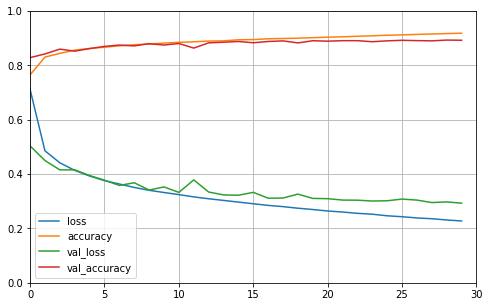

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_xlim(0, 30)
plt.gca().set_ylim(0, 1)
plt.show()

overfitting이 일어나지 않아서 모델이 완전히 수렴했다고 볼 수는 없지만 하이퍼파라미터 튜닝에 대해서는 뒤에서 다시 설명하므로 넘어가도록 하자.

`evaluate()`를 통해 test set에서 모델을 평가한다.

In [13]:
print(model.evaluate(X_test, y_test))

10000/10000 [==============================] - 0s 32us/sample - loss: 0.3239 - accuracy: 0.8829
[0.32388353894948957, 0.8829]


### 모델을 사용해 예측 만들기

`predict()`를 사용하면 새로운 샘플에 대한 예측을 만들 수 있다.

In [14]:
import numpy as np

X_new = X_test[:3]

# 확률로 출력하기
y_proba = model.predict(X_new)
print(y_proba.round(2))

# 클래스로 출력하기
y_pred = model.predict_classes(X_new)
print(y_pred)

# 클래스별 레이블 확인
print(np.array(class_names)[y_pred])

# 정답 확인
print(y_test[:3])

[[0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.99]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]]
[9 2 1]
['Ankle boot' 'Pullover' 'Trouser']
[9 2 1]


## Sequential API를 사용해 회귀용 다층 퍼셉트론 만들기

캘리포니아 주택 가격 데이터셋으로 회귀를 수행해보자.

`fetch_california_housing()`를 사용하면 `ocean_proximity`나 누락된 데이터 없이 수치 특성만 불러올 수 있으므로, 이를 사용해 데이터를 불러온다.

In [15]:
import os
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

dataset_path = os.path.join(os.getcwd(), "datasets")

if not os.path.isdir(dataset_path):
    os.makedirs(dataset_path)

housing = fetch_california_housing(data_home=dataset_path)

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data,
                                                              housing.target)
X_train, X_val, y_train, y_val = train_test_split(X_train_full,
                                                  y_train_full)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

회귀에 사용하는 모델은 출력이 활성화 함수가 없는 하나의 뉴런이고, 손실함수로 평균제곱오차를 사용한다.

여기서는 데이터에 노이즈가 많기 때문에 overfitting을 막기 위해 뉴런수가 하나뿐인 hidden layer만으로 구성하였다.

In [16]:
model = models.Sequential([
    layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    layers.Dense(1)
])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 30)                270       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(loss="mean_squared_error", optimizer="sgd")

In [19]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_val, y_val))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 58us/sample - loss: 0.9893 - val_loss: 0.6010
Epoch 2/20
11610/11610 [==============================] - 1s 45us/sample - loss: 0.5050 - val_loss: 0.4627
Epoch 3/20
11610/11610 [==============================] - 1s 44us/sample - loss: 0.4421 - val_loss: 0.4240
Epoch 4/20
11610/11610 [==============================] - 1s 45us/sample - loss: 0.4178 - val_loss: 0.4123
Epoch 5/20
11610/11610 [==============================] - 1s 45us/sample - loss: 0.4075 - val_loss: 0.4017
Epoch 6/20
11610/11610 [==============================] - 1s 45us/sample - loss: 0.4005 - val_loss: 0.4059
Epoch 7/20
11610/11610 [==============================] - 1s 43us/sample - loss: 0.3914 - val_loss: 0.4007
Epoch 8/20
11610/11610 [==============================] - 1s 45us/sample - loss: 0.3923 - val_loss: 0.3960
Epoch 9/20
11610/11610 [==============================] - 1s 45us/sample - loss: 0.3871 - val_l

In [20]:
print(model.evaluate(X_test, y_test))

5160/5160 [==============================] - 0s 22us/sample - loss: 0.3644
0.3643814557051474


In [21]:
X_new = X_test[:3]

y_pred = model.predict(X_new)
print(np.ravel(y_pred), y_test[:3])

[2.090295  2.641505  2.3155708] [1.777 2.168 2.548]


## 함수형 API를 사용해 복잡한 모델 만들기

순차적이지 않은 모델은 케라스의 Functional API를 통해 구현할 수 있다. 캘리포니아 주택 데이터셋으로 여러 직접 모델을 구현해보자.

### Wide & Deep 신경망
Wide & Deep 신경망은 입력의 일부 또는 전체가 출력층에 바로 연결되는 형태이며, 이를 통해 복잡한 패턴과 간단한 규칙을 모두 학습시킬 수 있는 모델이다.

이는 다음과 같이 구현할 수 있다.

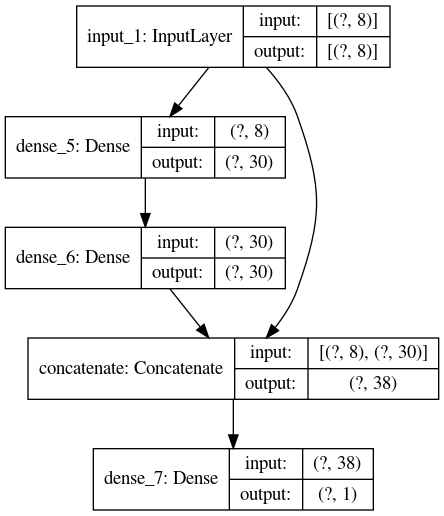

In [22]:
from tensorflow.keras.utils import plot_model

input_ = layers.Input(shape=X_train.shape[1:])
hidden1 = layers.Dense(30, activation="relu")(input_)
hidden2 = layers.Dense(30, activation="relu")(hidden1)
concat = layers.Concatenate()([input_, hidden2])
output = layers.Dense(1)(concat)

model = tf.keras.Model(inputs=[input_], outputs=[output])
plot_model(model, to_file='./images/wide_and_deep_model.png', show_shapes=True, show_layer_names=True)

이후 모델 컴파일, 학습, 평가, 예측은 모두 동일하므로 생략한다.

### 여러개의 입력을 다루는 모델
일부 특성은 짧은 경로로 전달하고 다른 특성들은 깊은 경로로 전달하고 싶은 경우에는 다음과 같이 구현할 수 있다.

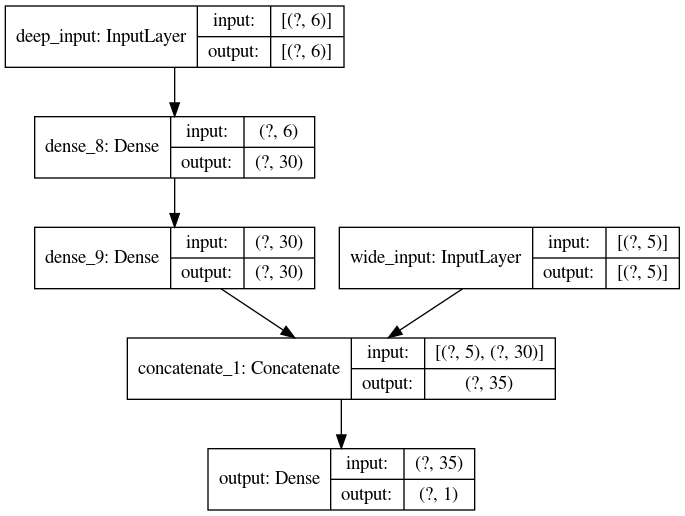

In [23]:
# 5개 특성을 짧은 경로, 6개 특성을 깊은 경로로 보낸다고 가정

input_A = layers.Input(shape=[5], name="wide_input")
input_B = layers.Input(shape=[6], name="deep_input")

hidden1 = layers.Dense(30, activation="relu")(input_B)
hidden2 = layers.Dense(30, activation="relu")(hidden1)

concat = layers.concatenate([input_A, hidden2])
output = layers.Dense(1, name="output")(concat)

model = tf.keras.Model(inputs=[input_A, input_B], outputs=[output])
plot_model(model, to_file='./images/multiple_input_model.png', show_shapes=True, show_layer_names=True)

이와 같은 경우에는 컴파일까지는 동일하지만, `fit()`, `evaluate()`, `predict()` 호출 시, 다음과 같이 입력마다 하나씩 행렬의 튜플을 전달해야 한다.

In [24]:
from tensorflow.keras import optimizers

model.compile(loss="mse", optimizer=optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_val_A, X_val_B = X_val[:, :5], X_val[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]

X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

# 튜플로 전달
history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_val_A, X_val_B), y_val))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 66us/sample - loss: 1.8201 - val_loss: 0.7965
Epoch 2/20
11610/11610 [==============================] - 1s 51us/sample - loss: 0.7221 - val_loss: 0.6598
Epoch 3/20
11610/11610 [==============================] - 1s 50us/sample - loss: 0.6356 - val_loss: 0.6112
Epoch 4/20
11610/11610 [==============================] - 1s 51us/sample - loss: 0.5903 - val_loss: 0.5749
Epoch 5/20
11610/11610 [==============================] - 1s 51us/sample - loss: 0.5619 - val_loss: 0.5517
Epoch 6/20
11610/11610 [==============================] - 1s 50us/sample - loss: 0.5410 - val_loss: 0.5369
Epoch 7/20
11610/11610 [==============================] - 1s 49us/sample - loss: 0.5247 - val_loss: 0.5239
Epoch 8/20
11610/11610 [==============================] - 1s 50us/sample - loss: 0.5122 - val_loss: 0.5209
Epoch 9/20
11610/11610 [==============================] - 1s 50us/sample - loss: 0.5005 - val_l

In [25]:
# test set에서 평가
mse_test = model.evaluate((X_test_A, X_test_B), y_test)

# 예측
print((model.predict((X_new_A, X_new_B))).ravel(), y_test[:3])

5160/5160 [==============================] - 0s 25us/sample - loss: 0.4448
[2.1873326 2.6987476 2.425388 ] [1.777 2.168 2.548]


### 여러개의 출력을 다루는 모델

여러개의 출력이 필요한 경우는 다양하다.
- 그림에 있는 물체를 분류하고, 위치도 알아야 하는 경우
    - 분류 결과와 물체의 좌표, 너비, 높이 값 모두를 출력해야 함
- 동일한 데이터에서 여러 작업을 수행하는 경우
    - 얼굴 사진에서 사람의 표정을 분류하고, 안경을 썼는지도 구별하는 경우
- regularization 기법으로 사용하는 경우
    - 신경망 구조 안에 보조 출력을 추가해, 하위 네트워크가 그 자체로도 유용한 것을 학습하는지 확인

여기서는 앞의 여러 입력을 받는 모델에 보조 출력을 추가하여 여러 개의 출력을 다루는 모델을 구현해보자.

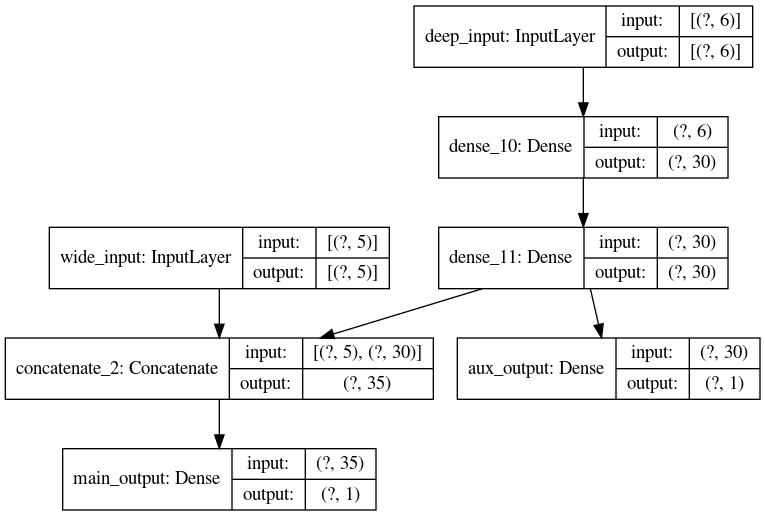

In [26]:
# 5개 특성을 짧은 경로, 6개 특성을 깊은 경로로 보낸다고 가정

input_A = layers.Input(shape=[5], name="wide_input")
input_B = layers.Input(shape=[6], name="deep_input")

hidden1 = layers.Dense(30, activation="relu")(input_B)
hidden2 = layers.Dense(30, activation="relu")(hidden1)

concat = layers.concatenate([input_A, hidden2])
main_output = layers.Dense(1, name="main_output")(concat)
aux_output = layers.Dense(1, name="aux_output")(hidden2)

model = tf.keras.Model(inputs=[input_A, input_B],
                       outputs=[main_output, aux_output])
plot_model(model, to_file='./images/multiple_input_output_model.png', show_shapes=True, show_layer_names=True)

여러개의 출력을 가지는 경우, 각 출력은 자신만의 손실함수가 필요하다. 따라서, 컴파일 시 loss function의 리스트를 전달해야 한다.

케라스는 기본적으로 여러 손실을 모두 더하여 최종 손실을 구하고, 이를 훈련에 사용한다. 따라서, 각 손실에 가중치를 부여할 수 있다.

In [27]:
# 보조 출력보다 주 출력에 큰 가중치를 준다고 가정
# (보조 출력은 regularization용으로만 사용되므로)
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer="sgd")

각 출력에 대한 레이블도 따로 제공해주어야 한다. 여기서는 주 출력과 보조 출력이 같은 것을 예측하므로, 동일한 레이블을 사용하였다.

In [28]:
history = model.fit(
    [X_train_A, X_train_B], [y_train, y_train], epochs=20,
    validation_data=([X_val_A, X_val_B], [y_val, y_val]))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 92us/sample - loss: 0.9941 - main_output_loss: 0.8682 - aux_output_loss: 2.1260 - val_loss: 0.8933 - val_main_output_loss: 0.8295 - val_aux_output_loss: 1.4657
Epoch 2/20
11610/11610 [==============================] - 1s 64us/sample - loss: 0.5843 - main_output_loss: 0.5094 - aux_output_loss: 1.2584 - val_loss: 0.5652 - val_main_output_loss: 0.4906 - val_aux_output_loss: 1.2360
Epoch 3/20
11610/11610 [==============================] - 1s 63us/sample - loss: 0.5288 - main_output_loss: 0.4646 - aux_output_loss: 1.1052 - val_loss: 0.5363 - val_main_output_loss: 0.4728 - val_aux_output_loss: 1.1065
Epoch 4/20
11610/11610 [==============================] - 1s 63us/sample - loss: 0.5044 - main_output_loss: 0.4498 - aux_output_loss: 0.9968 - val_loss: 0.5180 - val_main_output_loss: 0.4640 - val_aux_output_loss: 1.0030
Epoch 5/20
11610/11610 [==============================] - 1s 64us/s

`evaluate()`는 각 개별 손실과 총 손실을 반환한다.

In [29]:
total_loss, main_loss, aus_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])

print(total_loss, main_loss, aus_loss)

5160/5160 [==============================] - 0s 33us/sample - loss: 0.3613 - main_output_loss: 0.3429 - aux_output_loss: 0.5141
0.36134958230247793 0.3428896 0.5141361


`predict()`는 각 출력에 대한 예측을 반환한다.

In [30]:
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])
print(y_pred_main.ravel(), y_pred_aux.ravel(), y_test[:3])

[2.0023398 2.6572096 2.2754745] [1.903327  2.7078826 2.2644072] [1.777 2.168 2.548]


## 서브클래싱 API로 동적 모델 만들기

반복문을 포함하고, 다양한 크기를 다루고, 조건문을 가지는 등의 여러가지 동적인 구조가 필요한 경우에는 서브클래싱 API를 사용해 구현할 수 있다.

구현하는 방법은 먼저, `Model`클래스를 상속하고, 생성자 안에서 필요한 층을 만든다. 그리고 `call()`안에서 수행하고자 하는 연산을 구현하면 된다.

앞에서 구현한 다중 입출력 모델을 서브클래싱 API로 구현하면 다음과 같다.

In [31]:
class MultipleInputOutputModel(tf.keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        # name과 같은 표준 매개변수 처리
        super().__init__(**kwargs) 
        # 필요한 층 구현
        self.hidden1 = layers.Dense(units, activation=activation)
        self.hidden2 = layers.Dense(units, activation=activation)
        self.main_output = layers.Dense(1)
        self.aux_output = layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden1(hidden1)
        concat = layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.main_output(hidden2)
        return main_output, aux_output
    
model = MultipleInputOutputModel()

위 모델과 함수형 API 모델이 주된 차이점은 `call()`안에 원하는 어떤 계산도 사용할 수 있다는 것이다.(for문, if문, 텐서플로 저수준 연산 등)

하지만 모델 구조가 `call()`안에 숨겨져 있으므로 케라스가 쉽게 분석할 수 없다. 따라서 모델의 저장 및 복사가 불가능하며, `summary()`로 층의 자세한 내용을 확인할 수 없다.

## 모델 저장과 복원

Sequential API와 Functional API를 사용한 케라스 모델은 `model.save()`를 통해 다음과 같이 저장할 수 있다.

In [ ]:
model = models.Sequential([...])
model.compile([...])
model.fit([...])
model.save("my_keras_model.h5")

케라스는 HDF5 format을 사용해 모델을 저장하며, 저장되는 정보는 다음과 같다.
- 모델 구조
- 모든 층의 모델 파라미터(weights, biases)
- 모든 층의 하이퍼파라미터
- (하이퍼파라미터와 현재상태를 포함한) optimizer

모델을 다시 불러오는 것은 `load_model()`을 통해 다음과 같이 수행할 수 있다.

In [ ]:
model = keras.models.load_model("my_keras_model.h5")

서브클래싱 API에서는 위의 방법을 사용할 수 없으므로, `save_weights()`와 `load_weights()`를 통해 모델 파라미터를 저장 및 복원해야 하며, 그 외에는 모두 수동으로 저장 및 복원해야 한다.

## 콜백 사용하기

`fit()`의 `callbacks` 매개변수를 이용해 훈련의 시작과 끝, 에포크의 시작과 끝, 배치처리 전후에 호출할 객체를 지정해 원하는 작업을 수행할 수 있다.

다음은 `ModelCheckpoint`를 사용해 훈련 중 모델의 체크포인트를 저장하는 예이다.

In [ ]:
[...] # 모델 생성 및 컴파일
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_keras_model.h5")
history = model.fit(X_train, y_train, epochs=10,
                    callbacks=[checkpoint_cb])

훈련 중, 검증세트를 사용하면 최상의 검증 세트 점수에서 모델을 저장하도록 설정할 수도 있다.

이는 다음과 같이 `ModelCheckpoint` 생성 시, `save_best_only=True`로 지정하면 된다.

In [ ]:
[...] # 모델 생성 및 컴파일
checkpoint_cb =  tf.keras.callbacks.ModelCheckpoint("my_keras_model.h5",
                                                    save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb])

model = tf.keras.load_model("my_keras_model.h5") # 최상의 모델로 복원

`EarlyStopping` 콜백을 사용하면, 일정 epoch이상 검증 점수가 향상되지 않을 경우 훈련을 멈추도록 할 수도 있다.

`patience` 매개변수를 통해 몇번의 검증 성능 향상이 없을 때 멈출지를 선택할 수 있으며, `restore_best_weights=True`를 통해 학습 종료 후, 최상의 가중치를 복원할 수 있다.

다음은 10 epoch이상 검증 점수가 향상되지 않으면 훈련을 멈추는 콜백이며, 가장 좋은 점수를 낸 가중치를 저장하도록 설정한 예이다.

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)


사용자 정의 콜백을 직접 만들어 더욱 많은 제어를 수행할 수도 있다.

다음은 훈련동안 validation loss와 training loss의 비율을 출력하는 콜백이다.(즉, overfitting 감지)

In [ ]:
class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval\train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

## 텐서보드를 사용해 시각화하기

텐서보드는 매우 유용한 시각화 도구이다. 훈련 중 학습 곡선, 여러 실행간의 학습 곡선 비교, 계산 그래프 시작화 드으이 여러 기능을 제공한다.

텐서보드를 사용하기 위해서는, event file이라는 이진 로그 파일에 시각화 할 데이터를 출력해야 한다. 각각의 이진 데이터 레코드를 summary라고 부른다.

텐서보드 서버는 로그가 있는 directory를 모니터링하고, 자동으로 그래프를 업데이트 한다. 

일반적으로 각 실행 로그가 복잡하지 않도록 하기 위해 프로그램 실행 시마다 sub directory에 이벤트를 기록하도록 하고, 텐서보드는 root directory를 가리키도록 한다.

다음은 root directory를 정의하고, 날짜, 시간에 따른 sub directory 경로를 생성하는 함수의 예이다.

In [ ]:
import os
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

# Ex) './my_logs/run_2020_06_07-19_46_22'
run_logdir = get_run_logdir()

이제 다음과 같이 케라스의 `TensorBoard()`를 사용하면 된다.

In [ ]:
[...] # 모델 생성 및 컴파일
tensorboard_cb =  tf.keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_val, y_val),
                    callbacks=[tensorboard_cb])

이제 하나의 실행마다 하나의 서브 디렉토리가 생성되고, 훈련하는 동안 이벤트 파일을 만들고, summary를 기록하게 된다. 하이퍼파라미터를 바꾸고 실행 할때마다 계속해서 새로운 디렉토리가 생성되며 기록되므로 편리하다.

생성된 서브 디렉토리에는 훈련 로그를 위한 train 디렉토리와 검증 로그를 위한 validation 디렉토리가 생성되어 각각 이벤트 파일을 저장하게 된다.

train 디렉토리에는 profiling trace파일도 포함되는데, 텐서보드는 이 파일을 통해 모델의 각 부분에서 시간이 얼마나 소요되는지도 보여주므로, 성능 병목 지점을 찾는데에도 도움이 된다.

텐서보드를 실행할 때에는 root directory를 인자로 넘겨주며, 쉘에서 다음과 같이 실행하면 된다. (https:\/\/localhost:6006으로 접속하면 됨)

In [ ]:
$ tensorboard --logdir=./my_logs --port=6006